## 傅立叶变换
快速傅立叶，numpy

图像的频率是表征图像中灰度变化剧烈程度的指标，是灰度在平面空间上的梯度。因此图像的傅立叶变换表示了（灰度）分布的剧烈程度

白色：变换明显；黑色：变换缓慢。
没有谱中心处理：四角低频中心高频；谱中心化：四角高频中心低频。

refer：https://blog.csdn.net/fengyingv/article/details/109630535

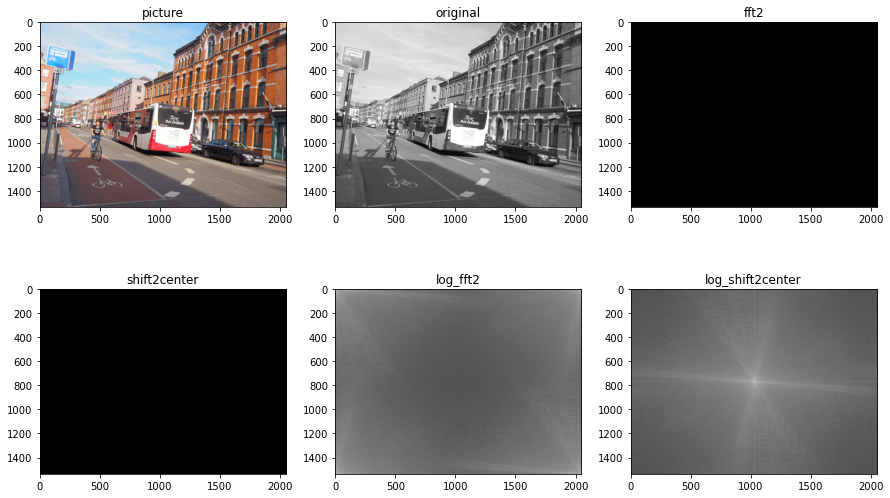

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 9))

img = plt.imread(path)
plt.subplot(231),plt.imshow(img),plt.title('picture')
 
#根据公式转成灰度图
img = 0.2126 * img[:,:,0] + 0.7152 * img[:,:,1] + 0.0722 * img[:,:,2]
 
#显示灰度图
plt.subplot(232),plt.imshow(img,'gray'),plt.title('original')
 
#进行傅立叶变换，并显示结果
fft2 = np.fft.fft2(img)
plt.subplot(233),plt.imshow(np.abs(fft2),'gray'),plt.title('fft2')
 
#将图像变换的原点移动到频域矩形的中心，并显示效果
shift2center = np.fft.fftshift(fft2)
plt.subplot(234),plt.imshow(np.abs(shift2center),'gray'),plt.title('shift2center')
 
#对傅立叶变换的结果进行对数变换，并显示效果
log_fft2 = np.log(1 + np.abs(fft2))
plt.subplot(235),plt.imshow(log_fft2,'gray'),plt.title('log_fft2')
 
#对中心化后的结果进行对数变换，并显示结果
log_shift2center = np.log(1 + np.abs(shift2center))
plt.subplot(236),plt.imshow(log_shift2center,'gray'),plt.title('log_shift2center')
plt.show()

## 逆滤波
https://blog.csdn.net/bingbingxie1/article/details/79398601

构建运动模糊模型
        
现假定相机不动，图像f(x,y)在图像面上移动并且图像f(x,y)除移动外不随时间变化。令x0(t)和y0(t)分别代表位移的x分量和y分量，那么在快门开启的时间T内，胶片上某点的总曝光量是图像在移动过程中一系列相应像素的亮度对该点作用之总和。也就是说，运动模糊图像是由同一图像在产生距离延迟后与原图像想叠加而成。如果快门开启与关闭的时间忽略不计，则有：
$g(x,y)=\int_{0}^{T}f[x-x_{0}(t)), y-y_{0}(t))]dt$


由于各种运动都是匀速直线运动的叠加，因而我们只需考虑匀速直线运动即可。但由于我们自身水平有限，且旨在探讨找到实现运动模糊复原方法的思想与方向，因而我们未能自行构建模型，而是借鉴了参考文献[1]中建立的运动模糊模型。关于本模型的理论依据参见参考文献[1].

下面我们描述一下该模型函数motion_process(image_size,motion_angle)，它包含两个参数：图像的尺寸大小image_size以及运动的角度motion_angle。

例如，当运动位移为9、运动角度为45度时，则该模型函数的构建过程如下：

首先是创建与图像同等大小的全0矩阵，然后找到全0矩阵的中心行数center_position，再计算出运动角度的tan值与cot值，算出运动的偏移量offset。
再令α≤45°时，PSF[int(center_position+offset),int(center_position-offset)]=1
α≥45°时，PSF[int(center_position-offset),int(center_position+offset)]=1
则该模型对应的图像如下图所示：
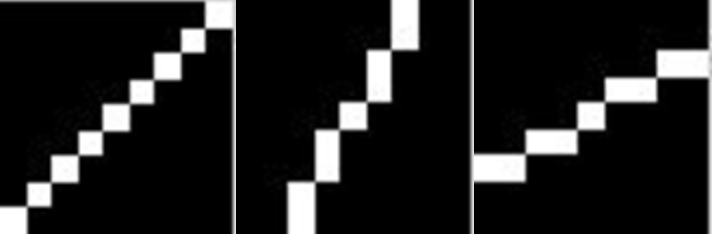

运动位移为9，运动角度分别为45°、30°、60°时，运动模糊模型对应的图像

(1536, 2048)
767.5


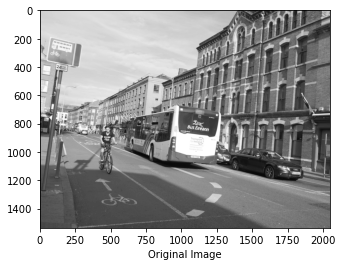

<Figure size 432x288 with 0 Axes>

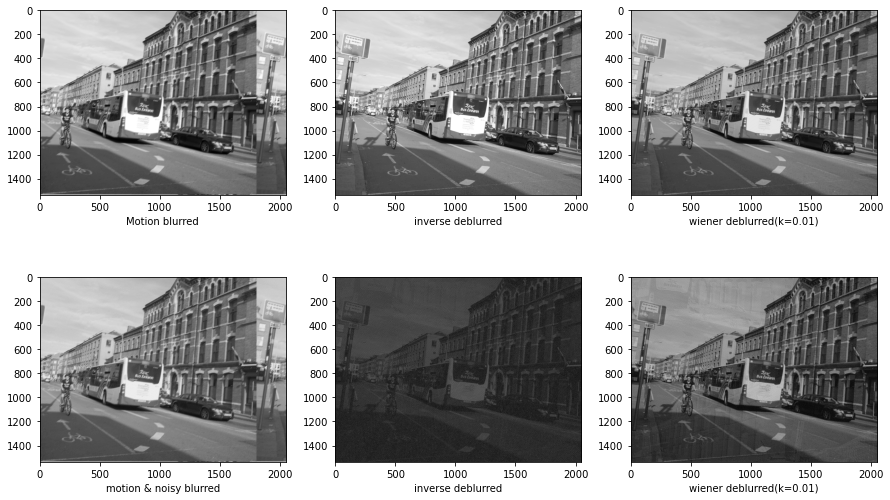

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2
 
# 仿真运动模糊
def motion_process(image_size,motion_angle):
    PSF = np.zeros(image_size)
    print(image_size)
    center_position=(image_size[0]-1)/2
    print(center_position)
 
    slope_tan=math.tan(motion_angle*math.pi/180)
    slope_cot=1/slope_tan
    if slope_tan<=1:
        for i in range(15):
            offset=round(i*slope_tan) #((center_position-i)*slope_tan)
            PSF[int(center_position+offset),int(center_position-offset)]=1
        return PSF / PSF.sum() #对点扩散函数进行归一化亮度
    else:
        for i in range(15):
            offset=round(i*slope_cot)
            PSF[int(center_position-offset),int(center_position+offset)]=1
        return PSF / PSF.sum()

# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)# 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF)+ eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred
 
def inverse(input, PSF, eps):  # 逆滤波
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps #噪声功率，这是已知的，考虑epsilon
    result = fft.ifft2(input_fft / PSF_fft) #计算F(u,v)的傅里叶反变换
    result = np.abs(fft.fftshift(result))
    return result
 
def wiener(input,PSF,eps,K=0.01):  #维纳滤波，K=0.01
    input_fft=fft.fft2(input)
    PSF_fft=fft.fft2(PSF) +eps
    PSF_fft_1=np.conj(PSF_fft) /(np.abs(PSF_fft)**2 + K)
    result=fft.ifft2(input_fft * PSF_fft_1)
    result=np.abs(fft.fftshift(result))
    return result

path = '/Users/panyining/Desktop/ireland.JPG'
image = cv2.imread(path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_h=image.shape[0]
img_w=image.shape[1]
plt.figure(1)
plt.xlabel("Original Image")
plt.gray()
plt.imshow(image)  #显示原图像

plt.figure(2)
plt.figure(figsize=(15, 9))
plt.gray()
#进行运动模糊处理
PSF = motion_process((img_h,img_w), 60)
blurred = np.abs(make_blurred(image, PSF, 1e-3))
 
plt.subplot(231)
plt.xlabel("Motion blurred")
plt.imshow(blurred)
 
result = inverse(blurred, PSF, 1e-3) #逆滤波
plt.subplot(232)
plt.xlabel("inverse deblurred")
plt.imshow(result)
 
result=wiener(blurred,PSF,1e-3)  #维纳滤波
plt.subplot(233)
plt.xlabel("wiener deblurred(k=0.01)")
plt.imshow(result)
 
blurred_noisy=blurred + 0.1 * blurred.std() * \
   np.random.standard_normal(blurred.shape) #添加噪声,standard_normal产生随机的函数
 
plt.subplot(234)
plt.xlabel("motion & noisy blurred")
plt.imshow(blurred_noisy)  #显示添加噪声且运动模糊的图像
 
result = inverse(blurred_noisy, PSF, 0.1+1e-3) #对添加噪声的图像进行逆滤波
plt.subplot(235)
plt.xlabel("inverse deblurred")
plt.imshow(result)
 
result=wiener(blurred_noisy,PSF,0.1+1e-3)   #对添加噪声的图像进行维纳滤波
plt.subplot(236)
plt.xlabel("wiener deblurred(k=0.01)")
plt.imshow(result)
 
plt.show()
